# Import Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
data = pd.read_csv('E-Commerce Shipping Data.csv')
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1




```
The dataset used for model building contained 10999 observations of 12 variables. The data contains the following information:
- ID                  : ID Number of Customers.
- Warehouse block     : The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
- Mode of shipment    : The Company Ships the products in multiple way such as Ship, Flight and Road.
- Customer care calls : The number of calls made from enquiry for enquiry of the shipment.
- Customer rating     : The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
- Cost of the product : Cost of the Product in US Dollars.
- Prior purchases     : The Number of Prior Purchase.
- Product importance  : The company has categorized the product in the various parameter such as low, medium, high.
- Gender              : Male and Female.
- Discount offered    : Discount offered on that specific product.
- Weight in gms       : It is the weight in grams.
- Reached on time     : It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.
```



In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


# Pre Processing

In [4]:
# Rename columns
data = data.rename(columns=lambda x: x.lower())
data= data.rename(columns={'reached.on.time_y.n': 'reached_ontime', 'cost_of_the_product': 'cost_before_discount', 'discount_offered': 'discount', 'weight_in_gms': 'weight'})
data['reached_ontime'] = 1 - data['reached_ontime']
data['cost_after_discount'] = data['cost_before_discount'] - (data['cost_before_discount'] * data['discount'] / 100)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10999 non-null  int64  
 1   warehouse_block       10999 non-null  object 
 2   mode_of_shipment      10999 non-null  object 
 3   customer_care_calls   10999 non-null  int64  
 4   customer_rating       10999 non-null  int64  
 5   cost_before_discount  10999 non-null  int64  
 6   prior_purchases       10999 non-null  int64  
 7   product_importance    10999 non-null  object 
 8   gender                10999 non-null  object 
 9   discount              10999 non-null  int64  
 10  weight                10999 non-null  int64  
 11  reached_ontime        10999 non-null  int64  
 12  cost_after_discount   10999 non-null  float64
dtypes: float64(1), int64(8), object(4)
memory usage: 1.1+ MB


In [5]:
# Drop not-importance column
data = data.drop(['id', 'customer_care_calls'], axis=1)

In [6]:
# Duplicate check
data_dup_count = data.duplicated().sum()
print(f"Total data duplicate: {data_dup_count}")

Total data duplicate: 0


In [7]:
# Missing value check
data.isnull().sum().reset_index().rename(columns={0: 'total'})

,index,total
0,warehouse_block,0
1,mode_of_shipment,0
2,customer_rating,0
3,cost_before_discount,0
4,prior_purchases,0
5,product_importance,0
6,gender,0
7,discount,0
8,weight,0
9,reached_ontime,0


In [8]:
# Invalid value check
category_column = data.select_dtypes(include='object')
for column in category_column:
  print(f"{column} column category:")
  print(f"{data[column].unique()}\n")

warehouse_block column category:
['D' 'F' 'A' 'B' 'C']

mode_of_shipment column category:
['Flight' 'Ship' 'Road']

product_importance column category:
['low' 'medium' 'high']

gender column category:
['F' 'M']



In [9]:
# Split data
from sklearn.model_selection import train_test_split
y = data['reached_ontime']
X = data.drop(['reached_ontime', 'discount', 'cost_before_discount'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

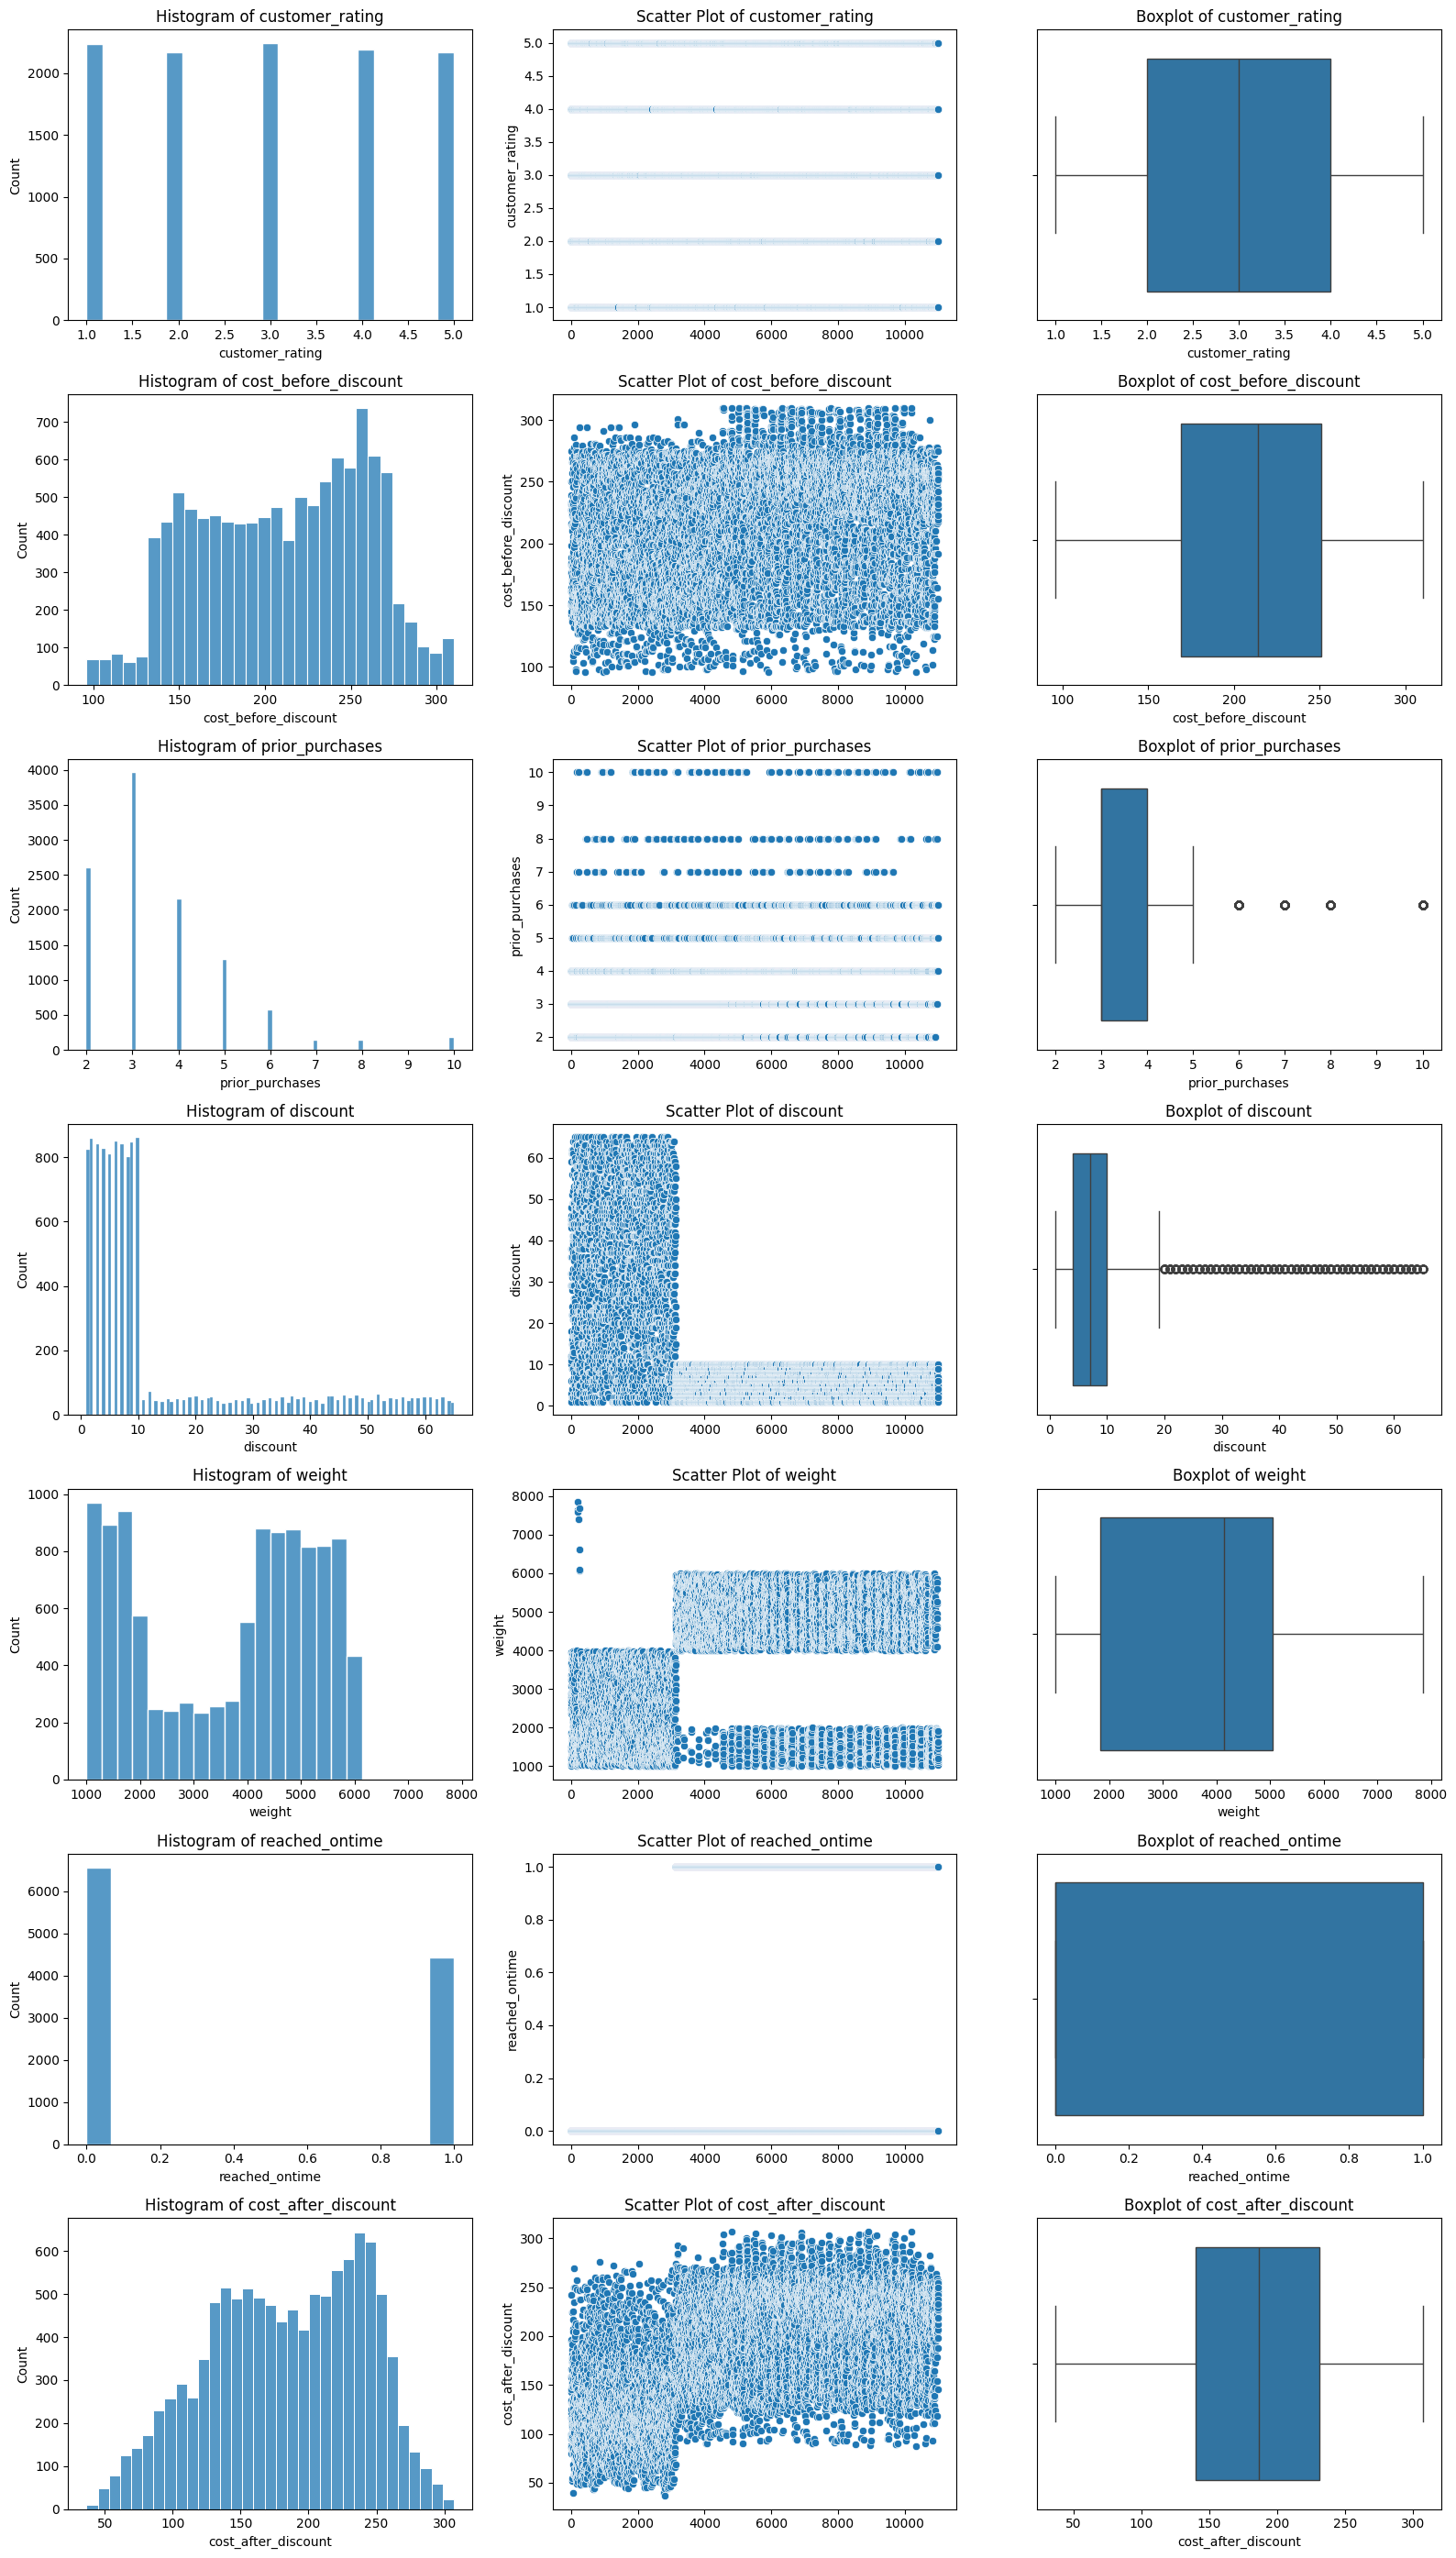

In [10]:
# Outlier check
def distribution_plot(data, features):
  fig, axes = plt.subplots(nrows=len(features), ncols=3, figsize=(16, 4*len(features)))
  plt.style.use('dark_background')
  for i in range(len(features)):
    # Histogram
    sns.histplot(data[features[i]], ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {features[i]}")
    # Scatter plot
    sns.scatterplot(x=range(len(data[features[i]])), y=data[features[i]], ax=axes[i, 1])
    axes[i, 1].set_title(f"Scatter Plot of {features[i]}")
    # Boxplot
    sns.boxplot(data[features[i]], orient='h', ax=axes[i, 2])
    axes[i, 2].set_title(f"Boxplot of {features[i]}")
  plt.tight_layout()
  plt.show()

numeric_column = data.select_dtypes(include='number').columns
distribution_plot(data, numeric_column)

In [11]:
# Categorical encoding (Label Encoder)
priority_map = {'low': 1, 'medium': 2, 'high': 3}
df_train['product_importance_encod'] = df_train['product_importance'].map(priority_map)
df_train = df_train.drop(['product_importance'], axis=1)
df_train = df_train.rename(columns={'product_importance_encod': 'product_importance'})

# Categorical encoding (OHE)
column_to_ohe = ['gender', 'mode_of_shipment', 'warehouse_block']
df_train = pd.get_dummies(df_train, columns=column_to_ohe, drop_first=True)
column_bool = ['gender_M', 'mode_of_shipment_Road', 'mode_of_shipment_Ship', 'warehouse_block_B', 'warehouse_block_C', 'warehouse_block_D', 'warehouse_block_F']
df_train[column_bool] = df_train[column_bool].astype(int)

df_train.head()

,customer_rating,prior_purchases,weight,cost_after_discount,reached_ontime,product_importance,gender_M,mode_of_shipment_Road,mode_of_shipment_Ship,warehouse_block_B,warehouse_block_C,warehouse_block_D,warehouse_block_F
1463,3,2,1980,113.90,0,2,0,0,1,0,0,0,1
10751,5,6,1222,241.56,1,1,0,0,1,0,0,0,1
3785,5,3,5045,174.80,1,1,0,0,1,0,0,0,1
3397,4,3,4774,174.24,1,1,0,0,1,0,0,0,1
5737,1,2,5281,233.12,1,1,0,1,0,0,0,0,1


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8249 entries, 1463 to 7270
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_rating        8249 non-null   int64  
 1   prior_purchases        8249 non-null   int64  
 2   weight                 8249 non-null   int64  
 3   cost_after_discount    8249 non-null   float64
 4   reached_ontime         8249 non-null   int64  
 5   product_importance     8249 non-null   int64  
 6   gender_M               8249 non-null   int64  
 7   mode_of_shipment_Road  8249 non-null   int64  
 8   mode_of_shipment_Ship  8249 non-null   int64  
 9   warehouse_block_B      8249 non-null   int64  
 10  warehouse_block_C      8249 non-null   int64  
 11  warehouse_block_D      8249 non-null   int64  
 12  warehouse_block_F      8249 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 902.2 KB


# EDA

## 1. Do certain warehouses tend to have more delays?

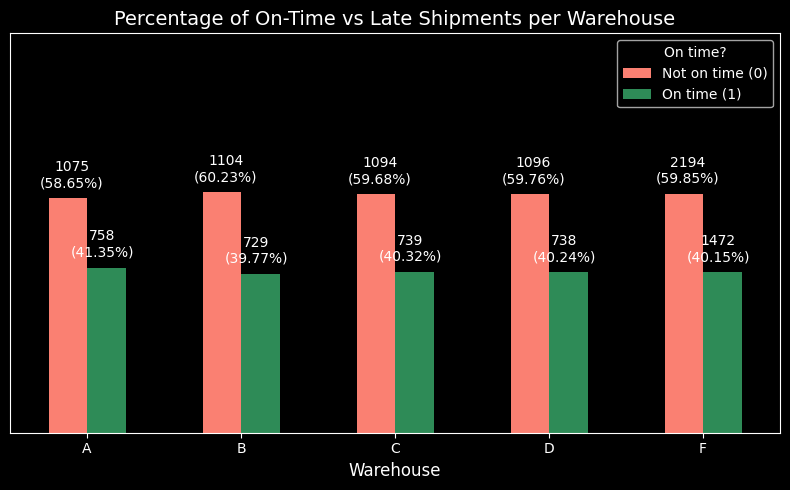

In [13]:
# Creat custom table for charting
warehouse_vs_ontime = data.groupby(['warehouse_block', 'reached_ontime']).size().unstack(fill_value=0)
total_per_warehouse = warehouse_vs_ontime.sum(axis=1)
warehouse_vs_ontime_percent = warehouse_vs_ontime.div(total_per_warehouse, axis=0) * 100

# Dark background
plt.style.use('dark_background')

# Creating chart
ax = warehouse_vs_ontime_percent[[0, 1]].plot(kind='bar', color=['salmon', 'seagreen'], figsize=(8, 5))
plt.title('Percentage of On-Time vs Late Shipments per Warehouse', fontsize=14, color='white')
plt.xlabel('Warehouse', fontsize=12, color='white')
plt.legend(title='On time?', labels=['Not on time (0)', 'On time (1)'], loc='upper right')
plt.ylim(0, 100)
ax.yaxis.set_visible(False)
plt.xticks(rotation=0, color='white')
plt.yticks(color='white')

# Adding percentage label
for i, (index, row) in enumerate(warehouse_vs_ontime_percent[[0, 1]].iterrows()):
    total = total_per_warehouse[index]
    for j, col in enumerate([0, 1]):
        percent = row[col]
        val = warehouse_vs_ontime.loc[index, col]
        label = f'{val}\n({percent:.2f}%)'
        ax.text(i + (j - 0.5) * 0.2, percent + 2, label,
                ha='center', va='bottom', fontsize=10, color='white')

plt.tight_layout()
plt.show()

## 2. Which shipment mode is most often on time?

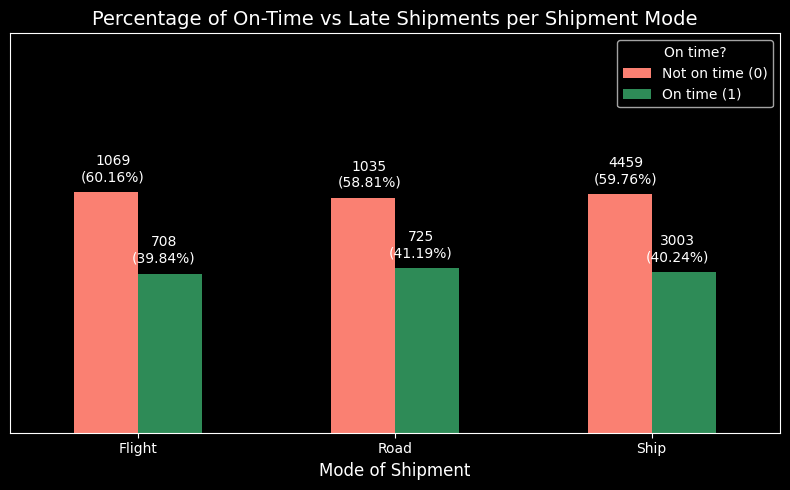

In [14]:
# Creat custom table for charting
shipmentmode_vs_ontime = data.groupby(['mode_of_shipment', 'reached_ontime']).size().unstack(fill_value=0)
total_per_shipmentmode = shipmentmode_vs_ontime.sum(axis=1)
shipmentmode_vs_ontime_percent = shipmentmode_vs_ontime.div(total_per_shipmentmode, axis=0) * 100

# Dark background
plt.style.use('dark_background')

# Creating chart
ax = shipmentmode_vs_ontime_percent[[0, 1]].plot(kind='bar', color=['salmon', 'seagreen'], figsize=(8, 5))
plt.title('Percentage of On-Time vs Late Shipments per Shipment Mode', fontsize=14, color='white')
plt.xlabel('Mode of Shipment', fontsize=12, color='white')
plt.legend(title='On time?', labels=['Not on time (0)', 'On time (1)'], loc='upper right')
plt.ylim(0, 100)
ax.yaxis.set_visible(False)
plt.xticks(rotation=0, color='white')
plt.yticks(color='white')

# Adding percentage label
for i, (index, row) in enumerate(shipmentmode_vs_ontime_percent[[0, 1]].iterrows()):
    total = total_per_shipmentmode[index]
    for j, col in enumerate([0, 1]):
        percent = row[col]
        val = shipmentmode_vs_ontime.loc[index, col]
        label = f'{val}\n({percent:.2f}%)'
        ax.text(i + (j - 0.5) * 0.2, percent + 2, label,
                ha='center', va='bottom', fontsize=10, color='white')

plt.tight_layout()
plt.show()

## 3. Do heavier products tend to be delayed?

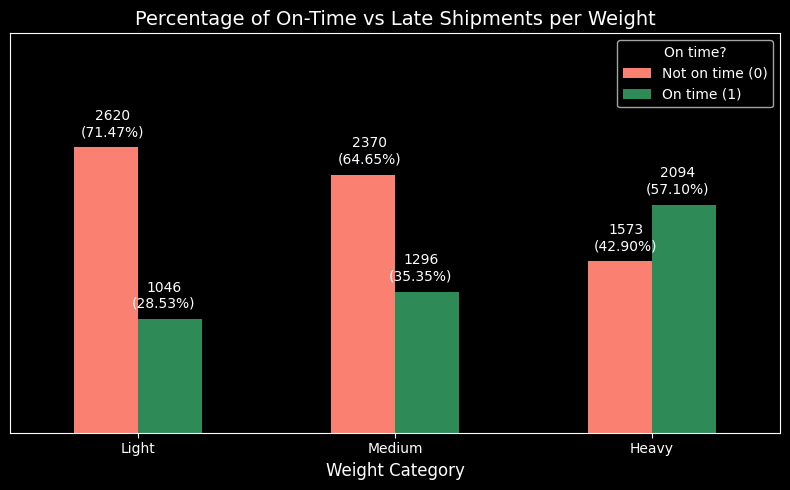

In [15]:
# Adding caterogy column for discount
data['weight_category'] = pd.qcut(data['weight'], q=3, labels=['Light', 'Medium', 'Heavy'])

# Creat custom table for charting
weight_vs_ontime = data.groupby(['weight_category', 'reached_ontime']).size().unstack(fill_value=0)
total_per_weight = weight_vs_ontime.sum(axis=1)
weight_vs_ontime_percent = weight_vs_ontime.div(total_per_weight, axis=0) * 100

# Dark background
plt.style.use('dark_background')

# Creating chart
ax = weight_vs_ontime_percent[[0, 1]].plot(kind='bar', color=['salmon', 'seagreen'], figsize=(8, 5))
plt.title('Percentage of On-Time vs Late Shipments per Weight', fontsize=14, color='white')
plt.xlabel('Weight Category', fontsize=12, color='white')
plt.legend(title='On time?', labels=['Not on time (0)', 'On time (1)'], loc='upper right')
plt.ylim(0, 100)
ax.yaxis.set_visible(False)
plt.xticks(rotation=0, color='white')
plt.yticks(color='white')

# Adding percentage label
for i, (index, row) in enumerate(weight_vs_ontime_percent[[0, 1]].iterrows()):
    total = total_per_weight[index]
    for j, col in enumerate([0, 1]):
        percent = row[col]
        val = weight_vs_ontime.loc[index, col]
        label = f'{val}\n({percent:.2f}%)'
        ax.text(i + (j - 0.5) * 0.2, percent + 2, label,
                ha='center', va='bottom', fontsize=10, color='white')

plt.tight_layout()
plt.show()

## 4. Do lower-priced products result in more shipments and more frequent delays?

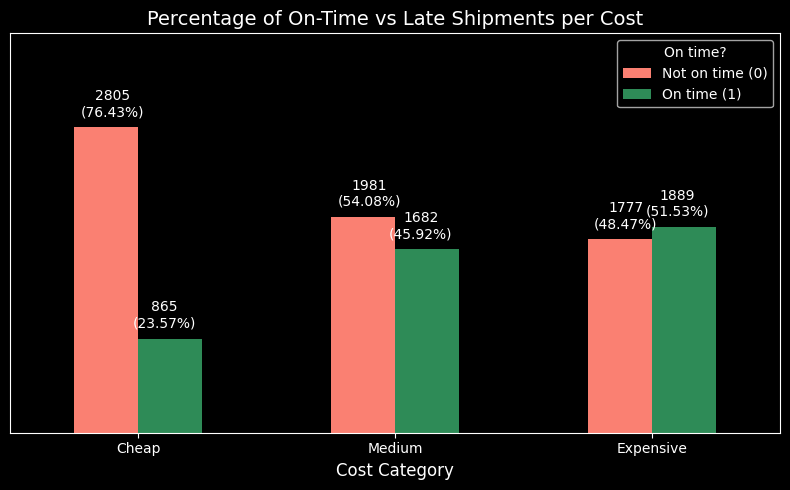

In [16]:
# Adding caterogy column for discount
data['cost_category'] = pd.qcut(data['cost_after_discount'], q=3, labels=['Cheap', 'Medium', 'Expensive'])

# Creat custom table for charting
cost_vs_ontime = data.groupby(['cost_category', 'reached_ontime']).size().unstack(fill_value=0)
total_per_cost = cost_vs_ontime.sum(axis=1)
cost_vs_ontime_percent = cost_vs_ontime.div(total_per_cost, axis=0) * 100

# Dark background
plt.style.use('dark_background')

# Creating chart
ax = cost_vs_ontime_percent[[0, 1]].plot(kind='bar', color=['salmon', 'seagreen'], figsize=(8, 5))
plt.title('Percentage of On-Time vs Late Shipments per Cost', fontsize=14, color='white')
plt.xlabel('Cost Category', fontsize=12, color='white')
plt.legend(title='On time?', labels=['Not on time (0)', 'On time (1)'], loc='upper right')
plt.ylim(0, 100)
ax.yaxis.set_visible(False)
plt.xticks(rotation=0, color='white')
plt.yticks(color='white')

# Adding percentage label
for i, (index, row) in enumerate(cost_vs_ontime_percent[[0, 1]].iterrows()):
    total = total_per_cost[index]
    for j, col in enumerate([0, 1]):
        percent = row[col]
        val = cost_vs_ontime.loc[index, col]
        label = f'{val}\n({percent:.2f}%)'
        ax.text(i + (j - 0.5) * 0.2, percent + 2, label,
                ha='center', va='bottom', fontsize=10, color='white')

plt.tight_layout()
plt.show()

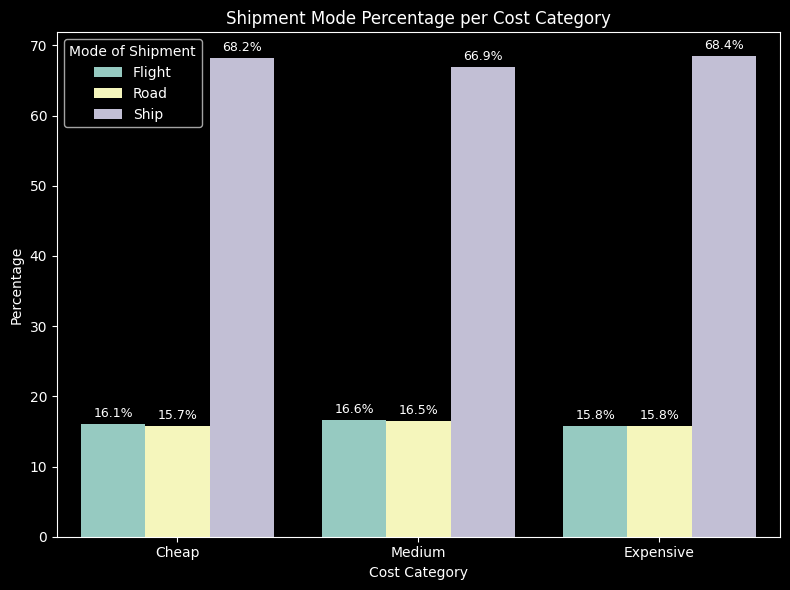

In [17]:
shipment_per_cost = data.groupby(['cost_category', 'mode_of_shipment']).size().reset_index(name='total')
shipment_per_cost['total_per_category'] = shipment_per_cost.groupby('cost_category')['total'].transform('sum')
shipment_per_cost['percentage'] = (shipment_per_cost['total'] / shipment_per_cost['total_per_category']) * 100

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=shipment_per_cost, x='cost_category', y='percentage', hue='mode_of_shipment')

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,   # X position (center of bar)
            height + 1,                       # Y position (slightly above bar)
            f'{height:.1f}%',                 # percentage label
            ha="center", fontsize=9)

# Axis labels and title
plt.ylabel("Percentage")
plt.xlabel("Cost Category")
plt.title("Shipment Mode Percentage per Cost Category")
plt.legend(title="Mode of Shipment")
plt.tight_layout()
plt.show()

## 5. How is the pattern of delivery status between customers?

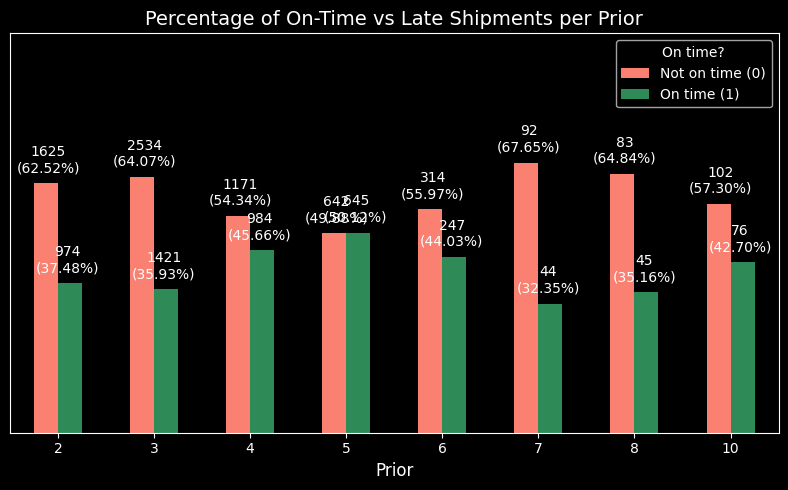

In [18]:
# Creat custom table for charting
prior_vs_ontime = data.groupby(['prior_purchases', 'reached_ontime']).size().unstack(fill_value=0)
total_per_prior = prior_vs_ontime.sum(axis=1)
prior_vs_ontime_percent = prior_vs_ontime.div(total_per_prior, axis=0) * 100

# Dark background
plt.style.use('dark_background')

# Creating chart
ax = prior_vs_ontime_percent[[0, 1]].plot(kind='bar', color=['salmon', 'seagreen'], figsize=(8, 5))
plt.title('Percentage of On-Time vs Late Shipments per Prior', fontsize=14, color='white')
plt.xlabel('Prior', fontsize=12, color='white')
plt.legend(title='On time?', labels=['Not on time (0)', 'On time (1)'], loc='upper right')
plt.ylim(0, 100)
ax.yaxis.set_visible(False)
plt.xticks(rotation=0, color='white')
plt.yticks(color='white')

# Adding percentage label
for i, (index, row) in enumerate(prior_vs_ontime_percent[[0, 1]].iterrows()):
    total = total_per_prior[index]
    for j, col in enumerate([0, 1]):
        percent = row[col]
        val = prior_vs_ontime.loc[index, col]
        label = f'{val}\n({percent:.2f}%)'
        ax.text(i + (j - 0.5) * 0.2, percent + 2, label,
                ha='center', va='bottom', fontsize=10, color='white')

plt.tight_layout()
plt.show()

# Preprocess Data Test

In [19]:
# Label encoding
df_test['product_importance_encod'] = df_test['product_importance'].map(priority_map)
df_test = df_test.drop(['product_importance'], axis=1)
df_test = df_test.rename(columns={'product_importance_encod': 'product_importance'})

# OHE
df_test = pd.get_dummies(df_test, columns=column_to_ohe, drop_first=True)
for col in column_bool:
    if col not in df_test.columns:
        df_test[col] = 0
df_test[column_bool] = df_test[column_bool].astype(int)

df_test.head()

,customer_rating,prior_purchases,weight,cost_after_discount,reached_ontime,product_importance,gender_M,mode_of_shipment_Road,mode_of_shipment_Ship,warehouse_block_B,warehouse_block_C,warehouse_block_D,warehouse_block_F
107,5,3,2053,159.84,0,3,1,0,1,0,0,0,1
5594,1,3,5572,206.80,0,1,0,1,0,0,0,0,0
6997,2,4,4042,208.55,1,1,0,0,0,0,0,0,1
3984,1,5,4672,158.40,1,1,0,0,0,0,0,1,0
3111,4,2,2419,128.24,0,2,0,0,1,1,0,0,0


In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2750 entries, 107 to 9617
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_rating        2750 non-null   int64  
 1   prior_purchases        2750 non-null   int64  
 2   weight                 2750 non-null   int64  
 3   cost_after_discount    2750 non-null   float64
 4   reached_ontime         2750 non-null   int64  
 5   product_importance     2750 non-null   int64  
 6   gender_M               2750 non-null   int64  
 7   mode_of_shipment_Road  2750 non-null   int64  
 8   mode_of_shipment_Ship  2750 non-null   int64  
 9   warehouse_block_B      2750 non-null   int64  
 10  warehouse_block_C      2750 non-null   int64  
 11  warehouse_block_D      2750 non-null   int64  
 12  warehouse_block_F      2750 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 300.8 KB


# Model Selection

## Logistic Regression

In [21]:
train_logreg = df_train.copy()
test_logreg = df_test.copy()

# Split data
## Train
X_train_logreg = train_logreg.drop(['reached_ontime'], axis=1)
y_train_logreg = train_logreg['reached_ontime']
## Test
X_test_logreg = test_logreg.drop(['reached_ontime'], axis=1)
y_test_logreg = test_logreg['reached_ontime']

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Training model and tuning hyperparameter
model_logreg = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
param_logreg = {'penalty': ['l1', 'l2'],
                'C': [0.01, 0.1, 1, 10]}
logreg_cv = GridSearchCV(model_logreg, param_logreg, cv=5, scoring='f1')
logreg_cv.fit(X_train_logreg, y_train_logreg)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='f1')

In [23]:
# Evaluate
y_train_pred_logreg = logreg_cv.predict(X_train_logreg)
y_test_pred_logreg = logreg_cv.predict(X_test_logreg)

print("Best params         : ", logreg_cv.best_params_)
print("F1 Score Train      : ", f1_score(y_train_logreg, y_train_pred_logreg))
print("F Score Test        : ", f1_score(y_test_logreg, y_test_pred_logreg))

Best params         :  {'C': 0.1, 'penalty': 'l2'}
F1 Score Train      :  0.49013047842087654
F Score Test        :  0.49502982107355864


## Decision Tree

In [24]:
train_dt = df_train.copy()
test_dt = df_test.copy()

# Split data
## Train
X_train_dt = train_dt.drop('reached_ontime', axis=1)
y_train_dt = train_dt['reached_ontime']
## Test
X_test_dt = test_dt.drop('reached_ontime', axis=1)
y_test_dt = test_dt['reached_ontime']

In [25]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=42)
param_dt = {'max_depth': np.arange(1, 10, 1)}
dt_cv = GridSearchCV(model_dt, param_dt, cv=5, scoring='f1')
dt_cv.fit(X_train_dt, y_train_dt)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='f1')

In [26]:
# Evaluate
y_train_pred_dt = dt_cv.predict(X_train_dt)
y_test_pred_dt = dt_cv.predict(X_test_dt)

print("Best params         : ", {k: int(v) if isinstance(v, np.integer) else float(v) if isinstance(v, np.floating) else v for k, v in dt_cv.best_params_.items()})
print("F1 Score Train      : ", f1_score(y_train_dt, y_train_pred_dt))
print("F1 Score Test       : ", f1_score(y_test_dt, y_test_pred_dt))

Best params         :  {'max_depth': 4}
F1 Score Train      :  0.7186567988512096
F1 Score Test       :  0.7134737545971247


## Random Forest

In [27]:
train_rf = df_train.copy()
test_rf = df_test.copy()

# Split data
## Train
X_train_rf = train_rf.drop('reached_ontime', axis=1)
y_train_rf = train_rf['reached_ontime']
## Test
X_test_rf = test_rf.drop('reached_ontime', axis=1)
y_test_rf = test_rf['reached_ontime']

In [28]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
param_rf = {'n_estimators': [50, 100, 150],
            'max_depth': np.arange(1, 10, 1),
            'max_features': ['sqrt', 'log2']}
rf_cv = GridSearchCV(model_rf, param_rf, cv=5, scoring='f1')
rf_cv.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 150]},
             scoring='f1')

In [29]:
# Evaluate
y_train_pred_rf = rf_cv.predict(X_train_rf)
y_test_pred_rf = rf_cv.predict(X_test_rf)

print("Best params       : ", {k: int(v) if isinstance(v, np.integer) else float(v) if isinstance(v, np.floating) else v for k, v in rf_cv.best_params_.items()})
print("F1 Score Train    : ", f1_score(y_train_rf, y_train_pred_rf))
print("F1 Score Test     : ", f1_score(y_test_rf, y_test_pred_rf))

Best params       :  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 50}
F1 Score Train    :  0.7379503977538605
F1 Score Test     :  0.6824276640790402


## XGBoost

In [30]:
train_xgb = df_train.copy()
test_xgb = df_test.copy()

# Split data
## Train
X_train_xgb = train_xgb.drop('reached_ontime', axis=1)
y_train_xgb = train_xgb['reached_ontime']
## Test
X_test_xgb = test_xgb.drop('reached_ontime', axis=1)
y_test_xgb = test_xgb['reached_ontime']

In [31]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_xgb = {'n_estimators': [50, 100],
             'max_depth': np.arange(1, 10, 1),
             'learning_rate': np.arange(0.01, 0.2, 0.01)}
xgb_cv = GridSearchCV(model_xgb, param_xgb, cv=5, scoring='f1')
xgb_cv.fit(X_train_xgb, y_train_xgb)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [50, 100]},
             scoring='f1')

In [32]:
# Evaluate
y_train_pred_xgb = xgb_cv.predict(X_train_xgb)
y_test_pred_xgb = xgb_cv.predict(X_test_xgb)

print("Best params       : ", {k: int(v) if isinstance(v, np.integer) else float(v) if isinstance(v, np.floating) else v for k, v in xgb_cv.best_params_.items()})
print("F1 Score Train    : ", f1_score(y_train_xgb, y_train_pred_xgb))
print("F1 Score Test     : ", f1_score(y_test_xgb, y_test_pred_xgb))

Best params       :  {'learning_rate': 0.09999999999999999, 'max_depth': 2, 'n_estimators': 50}
F1 Score Train    :  0.7114349775784753
F1 Score Test     :  0.7048458149779736


## LightGBM

In [33]:
train_lgbm = df_train.copy()
test_lgbm = df_test.copy()

# Split data
## Train
X_train_lgbm = train_lgbm.drop('reached_ontime', axis=1)
y_train_lgbm = train_lgbm['reached_ontime']
## Test
X_test_lgbm = test_lgbm.drop('reached_ontime', axis=1)
y_test_lgbm = test_lgbm['reached_ontime']

In [34]:
from lightgbm import LGBMClassifier

model_lgbm = LGBMClassifier(random_state=42)
param_lgbm = {'n_estimators': [50, 100],
             'max_depth': np.arange(1, 10, 1),
             'learning_rate': np.arange(0.01, 0.2, 0.01)}
lgbm_cv = GridSearchCV(model_lgbm, param_lgbm, cv=5, scoring='f1')
lgbm_cv.fit(X_train_lgbm, y_train_lgbm)

Streaming output truncated to the last 5000 lines.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 6599, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.404455 -> initscore=-0.386936
[LightGBM] [Info] Start training from score -0.386936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [50, 100]},
             scoring='f1')

In [35]:
# Evaluate
y_train_pred_lgbm = lgbm_cv.predict(X_train_lgbm)
y_test_pred_lgbm = lgbm_cv.predict(X_test_lgbm)

print("Best params       : ", {k: int(v) if isinstance(v, np.integer) else float(v) if isinstance(v, np.floating) else v for k, v in lgbm_cv.best_params_.items()})
print("F1 Score Train    : ", f1_score(y_train_lgbm, y_train_pred_lgbm))
print("F1 Score Test     : ", f1_score(y_test_lgbm, y_test_pred_lgbm))

Best params       :  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
F1 Score Train    :  0.7097500562936275
F1 Score Test     :  0.7052416609938734


# Features Contribution

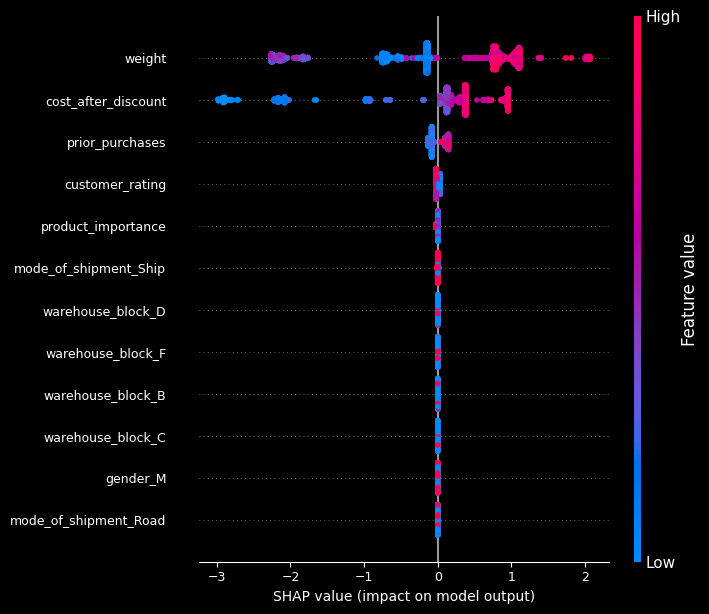

In [36]:
import shap
import matplotlib.pyplot as plt

best_model = lgbm_cv.best_estimator_
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_lgbm)
shap.summary_plot(shap_values,
                  X_test_lgbm,
                  plot_type='dot',
                  color=plt.get_cmap('coolwarm'),
                  show=False)
ax = plt.gca()
ax.xaxis.label.set_color('white')
ax.xaxis.label.set_fontsize(10)
ax.tick_params(axis='x', colors='white', labelsize=9)
ax.tick_params(axis='y', colors='white', labelsize=9)
ax.set_facecolor('black')
plt.gcf().set_facecolor('black')
plt.show()